In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import models
import torch.nn as nn

# 图像预处理：数据增强和标准化
transform = transforms.Compose([
    transforms.Resize((32, 32)),           # 将图像缩放为32x32大小
    transforms.RandomHorizontalFlip(),       # 随机水平翻转
    transforms.RandomRotation(20),           # 随机旋转
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机调整图像亮度、对比度、饱和度
    transforms.ToTensor(),                   # 将图像转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 数据标准化
])

# 自定义数据集类，用于加载图像和标签
class TinySegDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        
        # 读取标签文件
        with open(annotations_file, 'r') as f:
            self.annotations = f.readlines()
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        line = self.annotations[idx].strip()
        img_name, label = line.split(": ")
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像
        image = Image.open(img_path).convert('RGB')
        
        # 应用预处理
        if self.transform:
            image = self.transform(image)
        
        return image, int(label)

# 实例化数据集
annotations_file = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\labels.txt"  # 替换为你的标签文件路径
img_dir = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\JPEGImages"  # 图像所在的目录
dataset = TinySegDataset(annotations_file, img_dir, transform)

# 切分数据集
test_size = 624
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 查看类别分布
labels = [int(line.strip().split(": ")[1]) for line in open(annotations_file)]
label_counts = {i: labels.count(i) for i in set(labels)}  # 统计每个类别的样本数量

# 计算每个类别的采样权重
class_weights = {i: 1.0 / count for i, count in label_counts.items()}
weights = [class_weights[label] for label in labels[:train_size]] # 根据每个图像的标签分配权重

# 创建 WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        # 第一层卷积：输入通道为 3，输出通道为 6 (支持 RGB 图像)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # 输出尺寸: (6, 28, 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸: (6, 14, 14)
        
        # 第二层卷积：输入通道为 6，输出通道为 16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 输出尺寸: (16, 10, 10)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸: (16, 5, 5)
        
        # 全连接层：根据卷积输出调整输入尺寸
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 展平后尺寸为 16 * 5 * 5 = 400
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # 展平

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 输出
        return x 

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import SGD

# 定义 LeNet Lightning 模型
class LeNetLightning(pl.LightningModule):
    def __init__(self, num_classes=5):
        super().__init__()
        self.model = LeNet(num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        accuracy = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.0005, momentum=0.9)
    


In [ ]:
# 初始化模型
model = LeNetLightning()

# TensorBoard Logger
logger = TensorBoardLogger("voc_logs", name="lenet")

# 创建 PyTorch Lightning Trainer
trainer = pl.Trainer(
    devices=1,           # 使用 1 个 GPU
    accelerator='gpu',   # 使用 GPU 加速
    max_epochs = 5,        # 设置训练的 epoch 数量
    enable_progress_bar=True,
    logger=logger 
)

# 开始训练
trainer.fit(model, train_loader)

# 保存训练好的模型
trainer.save_checkpoint("lenet_voc_trained.pt")


In [ ]:
from tqdm import tqdm
# 加载训练后的模型
inference_model = LeNetLightning.load_from_checkpoint("lenet_voc_trained.pt", map_location="cuda")
inference_model.eval()  # 设置为评估模式

# 推断函数
def get_prediction(x, model: pl.LightningModule):
    model.freeze()  # 准备模型进行预测
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

# 进行推断
true_y, pred_y = [], []

for batch in tqdm(test_loader, total=len(test_loader)):
    x, y = batch
    x = x.to("cuda")  # 将数据放到GPU

    # 获取预测结果
    preds, _ = get_prediction(x, inference_model)
    true_y.extend(y.cpu().numpy())  # 收集真实标签
    pred_y.extend(preds.cpu().numpy())  # 收集预测标签

# 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))


In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

# 图像预处理：数据增强和标准化
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # 将图像缩放为224x224大小
    transforms.RandomHorizontalFlip(),       # 随机水平翻转
    transforms.RandomRotation(20),           # 随机旋转
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机调整图像亮度、对比度、饱和度
    transforms.ToTensor(),                   # 将图像转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 数据标准化
])

# 自定义数据集类，用于加载图像和标签
class TinySegDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        
        # 读取标签文件
        with open(annotations_file, 'r') as f:
            self.annotations = f.readlines()
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        line = self.annotations[idx].strip()
        img_name, label = line.split(": ")
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像
        image = Image.open(img_path).convert('RGB')
        
        # 应用预处理
        if self.transform:
            image = self.transform(image)
        
        return image, int(label)

# 实例化数据集
annotations_file = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\labels.txt"  # 替换为你的标签文件路径
img_dir = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\JPEGImages"  # 图像所在的目录
dataset = TinySegDataset(annotations_file, img_dir, transform)

# 切分数据集
test_size = 624
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 获取标签分布
labels = [int(line.strip().split(": ")[1]) for line in open(annotations_file)]
label_counts = {i: labels.count(i) for i in set(labels)}  # 统计每个类别的样本数量

# 使用 sklearn 计算类别权重
class_weights = compute_class_weight('balanced', classes=list(label_counts.keys()), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)




In [76]:
# 定义 LeNet 模型
class LeNet(nn.Module):
    def __init__(self, num_classes=5):
        super(LeNet, self).__init__()
        
        # 第一层卷积：输入通道为 3，输出通道为 32 (支持 RGB 图像)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # 输出尺寸: (32, 224, 224)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸: (32, 112, 112)
        
        # 第二层卷积：输入通道为 32，输出通道为 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # 输出尺寸: (64, 112, 112)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸: (64, 56, 56)
        
        # 第三层卷积：输入通道为 64，输出通道为 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)  # 输出尺寸: (128, 56, 56)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸: (128, 28, 28)
        
        # 添加 Dropout 防止过拟合
        self.dropout = nn.Dropout(0.5)
        
        # 全连接层：根据卷积输出调整输入尺寸
        self.fc1 = nn.Linear(128 * 28 * 28, 1024)  # 展平后尺寸为 128 * 28 * 28 = 100352
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)  # 展平
        x = self.dropout(torch.relu(self.fc1(x)))  # 添加 Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 输出
        return x 

# 定义 LeNet Lightning 模型
class LeNetLightning(pl.LightningModule):
    def __init__(self, num_classes=5):
        super().__init__()
        self.model = LeNet(num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)  # 为损失函数添加类别权重

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        accuracy = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)  # 使用 Adam 优化器
        return optimizer

# 初始化模型
checkpoint_path = "lenet_voc_trained.pt"
model = LeNetLightning.load_from_checkpoint(checkpoint_path);

# TensorBoard Logger
logger = TensorBoardLogger("voc_logs", name="lenet")

# 创建 PyTorch Lightning Trainer
trainer = pl.Trainer(
    devices=1,           # 使用 1 个 GPU
    accelerator='gpu',   # 使用 GPU 加速
    max_epochs = 1,     # 设置训练的 epoch 数量

    enable_progress_bar=True,
    logger=logger 
)

# 开始训练
trainer.fit(model, train_loader)

# 保存训练好的模型
trainer.save_checkpoint("lenet_voc_trained.pt")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | LeNet            | 103 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
103 M     Trainable params
0         Non-trainable params
103 M     Total params
414.190   Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
d:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [81]:
from tqdm import tqdm
# 加载训练后的模型
inference_model = LeNetLightning.load_from_checkpoint("lenet_voc_trained.pt", map_location="cuda")
inference_model.eval()  # 设置为评估模式

# 推断函数
def get_prediction(x, model: pl.LightningModule):
    model.freeze()  # 准备模型进行预测
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities



# 进行推断
true_y, pred_y = [], []

for batch in tqdm(test_loader, total=len(test_loader)):
    x, y = batch
    x = x.to("cuda")  # 将数据放到GPU

    # 获取预测结果
    preds, _ = get_prediction(x, inference_model)
    
    true_y.extend(y.cpu().numpy())  # 收集真实标签
    pred_y.extend(preds.cpu().numpy())  # 收集预测标签

# 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

              precision    recall  f1-score   support

           0      0.760     0.792     0.776        48
           1      0.491     0.540     0.514        50
           2      0.797     0.668     0.726       346
           3      0.592     0.689     0.637       103
           4      0.404     0.571     0.473        77

    accuracy                          0.659       624
   macro avg      0.609     0.652     0.625       624
weighted avg      0.687     0.659     0.667       624



100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


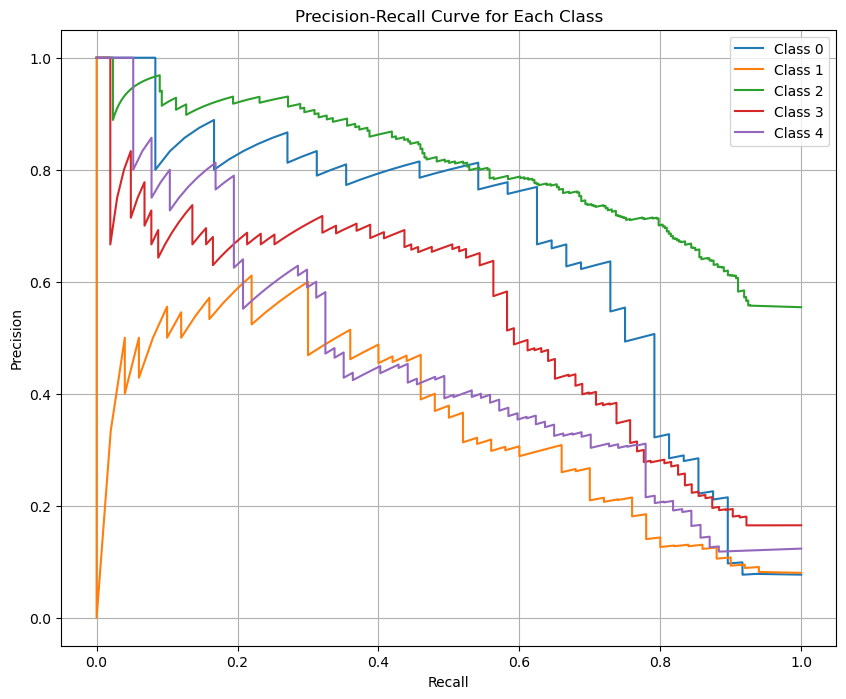

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# 1. 对标签进行二值化处理
true_y_binarized = label_binarize(true_y, classes=[0, 1, 2, 3, 4])  # 假设有5个类别，标签为0-4
pred_probs = np.zeros((len(true_y), 5))  # 用于存储每个类别的预测概率

# 2. 获取每个样本在每个类别上的预测概率
for batch_idx, batch in enumerate(tqdm(test_loader, total=len(test_loader))):
    x, _ = batch
    x = x.to("cuda")
    
    with torch.no_grad():
        preds = inference_model(x)  # 获取模型输出
        preds = torch.softmax(preds, dim=1)  # 计算每个类别的概率
        pred_probs[batch_idx * len(x):(batch_idx + 1) * len(x)] = preds.cpu().numpy()

# 3. 绘制每个类别的PR曲线
plt.figure(figsize=(10, 8))
for i in range(5):  # 假设类别数量为5
    precision, recall, _ = precision_recall_curve(true_y_binarized[:, i], pred_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="best")
plt.grid(True)
plt.show()
